In [1]:
import pandas as pd

from cta.etl import fetch_daily_ridership_data, fetch_station_info

In [2]:
raw_riders_df = fetch_daily_ridership_data()

## Determine how to attribute riders to train lines

The above `raw_riders_df` lists riders per station, but we need to be able to roll those up to entire train lines. To do this, we use information about the individual stations provided by the CTA to determine which train lines are associated with each stations. We then make some sensible corrections (namely, distinguishing between the Purple Line and the Purple Line Express, and accounting for the fact that the latter doesn't run on weekends), and then split the station's ridership evenly among the train lines that it is associated with.

### Determine which lines are associated with each station

In [21]:
station_info_df = fetch_station_info()
station_info_df.columns = station_info_df.columns.str.lower()

# Clean up column names
old_names = ['red', 'blue', 'g', 'brn', 'p', 'pexp', 'y', 'pnk', 'o']
train_lines = ['red', 'blue', 'green', 'brown', 'purple', 'purple_express', 'yellow', 'pink', 'orange']
mapper = dict(zip(old_names, train_lines))
station_info_df = station_info_df.rename(columns=mapper)

# Fix a couple of one-off typos in the data
station_info_df['station_descriptive_name'] = station_info_df['station_descriptive_name'].str.replace('  ', ' ')

station_info_df['station_name'] = station_info_df['station_name'].str.replace('Ran Ryan', 'Dan Ryan')
station_info_df['station_descriptive_name'] = station_info_df['station_descriptive_name'].str.replace('Ran Ryan', 'Dan Ryan')

# All normal Purple Line stations are also marked express, let's instead make them distinct
station_info_df['purple_express'] = (station_info_df['purple_express']) & (~station_info_df['purple'])

#Reduce df to relevant columns
station_info_cols = ['station_name', 'station_descriptive_name', 'map_id']
station_info_df = station_info_df[station_info_cols + train_lines]
station_info_df = station_info_df.drop_duplicates()  # Each station has a separate entry for inbound/outbound, we only care about the actual station

# For stations in the loop, different directions have different trains available, but we don't really
# care about that for raw ridership data, so do a quick grouping and aggregation so we end up with
# 1 row per station, with all available train lines for that station marked.
aggs = dict(zip(train_lines, [pd.NamedAgg(column=t, aggfunc=lambda x: any(x)) for t in train_lines]))
station_lines = station_info_df.sort_values('map_id').groupby('map_id').agg(**aggs).reset_index()
station_lines

,map_id,red,blue,green,brown,purple,purple_express,yellow,pink,orange
0,40010,False,True,False,False,False,False,False,False,False
1,40020,False,False,True,False,False,False,False,False,False
2,40030,False,False,True,False,False,False,False,False,False
3,40040,False,False,False,True,False,True,False,True,True
4,40050,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
138,41660,True,False,False,False,False,False,False,False,False
139,41670,False,False,True,False,False,False,False,False,False
140,41680,False,False,False,False,False,False,True,False,False
141,41690,False,False,True,False,False,False,False,False,False


In [28]:
# Melt the above result into a long dataframe, and join back to station info
# data to get 1 row per station per train line

stations = station_info_df[station_info_cols].drop_duplicates()
stations = stations.merge(station_lines, on='map_id')

stations = stations.melt(id_vars=station_info_cols, value_vars=train_lines, var_name='line')
stations = stations[stations['value']].drop('value', axis=1)

# Also add in # of train lines that touch this station - will use this later to split
# ridership at junction stations and attribute rides to individual train lines
n_lines = stations.groupby(station_info_cols).agg(n_lines=pd.NamedAgg(column='map_id', aggfunc='count')).reset_index()
stations = stations.merge(n_lines, on=station_info_cols, how='left')

stations

,station_name,station_descriptive_name,map_id,line,n_lines
0,69th,69th (Red Line),40990,red,1
1,79th,79th (Red Line),40240,red,1
2,95th/Dan Ryan,95th/Dan Ryan (Red Line),40450,red,1
3,Addison,Addison (Red Line),41420,red,1
4,Argyle,Argyle (Red Line),41200,red,1
...,...,...,...,...,...
185,Roosevelt,"Roosevelt (Red, Orange & Green Lines)",41400,orange,3
186,State/Lake,"State/Lake (Brown, Green, Orange, Pink & Purpl...",40260,orange,5
187,Washington/Wells,"Washington/Wells (Brown, Orange, Purple & Pink...",40730,orange,4
188,Western,Western (Orange Line),40310,orange,1


### Apply some corrections related to the Purple Line Express

In [58]:
# Do some dataset cleaning
cleaned_df = raw_riders_df.copy()

cleaned_df['date'] = pd.to_datetime(cleaned_df['date'], format='%m/%d/%Y')

cleaned_df = cleaned_df.merge(stations, left_on='station_id', right_on='map_id')

# Purple Express only runs on weekdays, so drop non-weekday entries for that line, and
# adjust the # of possible lines for the relevant station on those non-weekdays to be n-1
is_p_exp = cleaned_df['line'] == 'purple_express'
is_non_weekday = cleaned_df['daytype'] != 'W'
p_exp_stations = cleaned_df[is_p_exp]['station_id'].unique()

needs_correction = cleaned_df['station_id'].isin(p_exp_stations) & is_non_weekday
cleaned_df.loc[needs_correction, 'n_lines'] = cleaned_df.loc[needs_correction, 'n_lines'] - 1

cleaned_df = cleaned_df[~((is_non_weekday) & (is_p_exp))]

cleaned_df['line_corrected_ridership'] = cleaned_df['rides'] / cleaned_df['n_lines']


Obtain our final dataframe, which is ridership per day per train line

In [69]:
df = cleaned_df.groupby(['date', 'daytype', 'line'])['line_corrected_ridership'].sum().reset_index()
df = df.rename({'line_corrected_ridership': 'rides'}, axis=1)

In [67]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style='white', color_codes=True)
blue, red, amber = sb.xkcd_palette(['windows blue', 'pale red', 'amber'])

Some quick visualizations to ensure our data looks like we expect

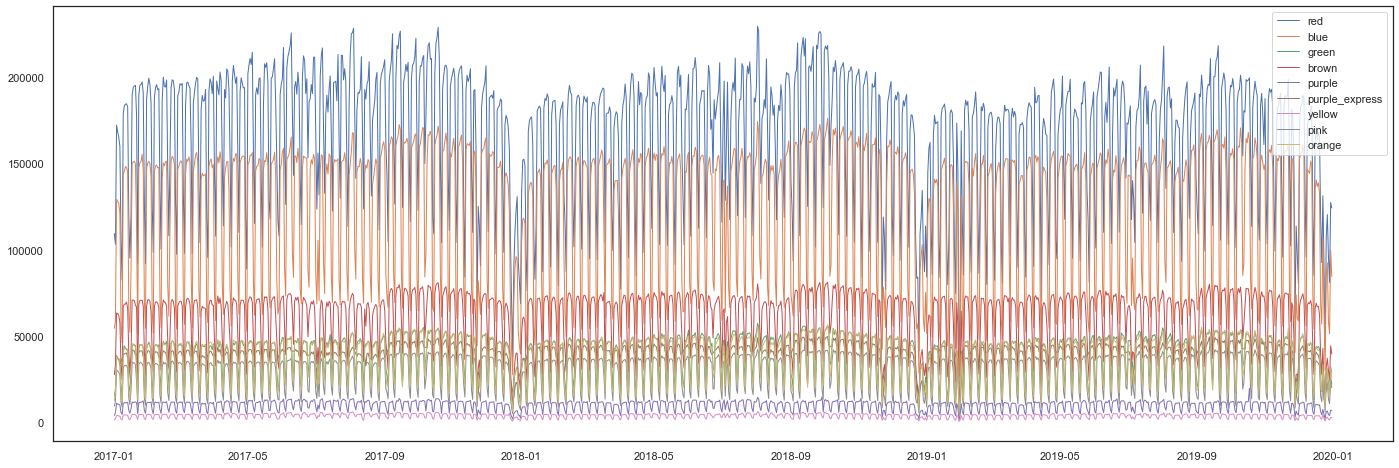

In [80]:
fig = plt.figure(figsize=(24, 8))
subplt = plt.subplot(111)

for line in train_lines:
    data = df[df['line'] == line].copy()

    data = data[
        (data['date'] >= pd.Timestamp('2017-01-01')) &
        (data['date'] < pd.Timestamp('2020-01-01'))
    ]

    data = data.sort_values('date')
    subplt.plot(data['date'], data['rides'], linestyle='-', lw=1, label=line)

subplt.legend()